In [15]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange


import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed

from flygym.mujoco import Parameters
from flygym.mujoco.arena.base import BaseArena, FlatTerrain
from flygym.mujoco import Parameters

from nmf_project import (
    NeuromechflyProject,
    all_actuated_dof,)


from nmf_grooming import (
    NeuromechflyGrooming,
    all_groom_dofs,
    load_grooming_data,
    plot_state_and_contacts,
)
from scipy.signal import find_peaks, medfilt
from IPython.display import Video

from flygym.mujoco.examples.rule_based_controller import PreprogrammedSteps

In [2]:
# Joint angles according to indices
LF_COXA = 0
LF_COXA_ROLL = 1
LF_COXA_YAW = 2
LF_FEMUR = 3
LF_FEMUR_ROLL = 4
LF_TIBIA = 5
LF_TARSUS = 6

LM_COXA = 7
LM_COXA_ROLL = 8
LM_COXA_YAW = 9
LM_FEMUR = 10
LM_FEMUR_ROLL = 11
LM_TIBIA = 12
LM_TARSUS = 13

LH_COXA = 14
LH_COXA_ROLL = 15
LH_COXA_YAW = 16
LH_FEMUR = 17
LH_FEMUR_ROLL = 18
LH_TIBIA = 19
LH_TARSUS = 20

RF_COXA = 21
RF_COXA_ROLL = 22
RF_COXA_YAW = 23
RF_FEMUR = 24
RF_FEMUR_ROLL = 25
RF_TIBIA = 26
RF_TARSUS = 27

RM_COXA = 28
RM_COXA_ROLL = 29
RM_COXA_YAW = 30
RM_FEMUR = 31
RM_FEMUR_ROLL = 32
RM_TIBIA = 33
RM_TARSUS = 34

RH_COXA = 35
RH_COXA_ROLL = 36
RH_COXA_YAW = 37
RH_FEMUR = 38
RH_FEMUR_ROLL = 39
RH_TIBIA = 40
RH_TARSUS = 41

In [3]:
run_time = 1

sim_params = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_adhesion=True,
)

actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

In [4]:
target_num_steps = int(run_time / sim_params.timestep) # 10'000


In [5]:
nmf = flygym.mujoco.NeuroMechFly(Parameters(
    enable_adhesion=True, 
    draw_adhesion=True,
    render_camera="Animat/camera_left"))

preprogrammed_steps = PreprogrammedSteps()

swing_periods = preprogrammed_steps.swing_period

legs = preprogrammed_steps.legs

actuated_joints = preprogrammed_steps.dofs_per_leg

standing_action = []

for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1]))
    else:
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

standing_action = {'joints': standing_action, "adhesion": np.zeros(len(legs))}

for i in range(int(0.2//nmf.timestep)):
    nmf.step(standing_action)



#### Move middle legs to the back

In [6]:
nmf.reset()
foreleg_ids = np.zeros(target_num_steps)
middle_stance_ids = np.linspace(swing_periods["RM"][1], -1/4*np.pi, target_num_steps)
hind_swings_ids = np.zeros(target_num_steps)

adhesion_action = np.array([1.0 if leg.endswith("F") else 0.0 for leg in legs])
all_joint_angles = []

for i in trange(target_num_steps):
    joint_angles = []
    for leg in legs:
        if leg.endswith("H"):
            joint_angles.extend(preprogrammed_steps.get_joint_angles(leg, hind_swings_ids[i]))
        elif leg.endswith("M"):
            joint_angles.extend(preprogrammed_steps.get_joint_angles(leg, middle_stance_ids[i]))
        else:
            joint_angles.extend(preprogrammed_steps.get_joint_angles(leg, foreleg_ids[i]))
    all_joint_angles.append(joint_angles.copy())

    action = {'joints': np.array(joint_angles), "adhesion": adhesion_action}
    nmf.step(action)
    nmf.render()
nmf.save_video("./outputs/b.mp4")

# Save the last joint angles
last_joint_angles = all_joint_angles[-1]


100%|██████████| 10000/10000 [00:36<00:00, 273.83it/s]


#### Try to move abdoment but didn't work out

In [ ]:
# Try to move abdomen, didn't work out

# from example given in miniproject
# abdomen_control = np.sin(
#     2 * 2 * np.pi * np.linspace(0, 0.5, nbre_steps) / 0.5
# )
# abdomen_control = abdomen_control * np.pi / 5 + np.pi / 10
# abdomen_control = np.tile(abdomen_control, (5, 1)).T # shape (nbre_steps, 5)


# for i in range(len(all_actuated_dof)):
#     if i == 42: # LPedicel
#         all_joint_pos[:,i] = np.linspace(0,0, nbre_steps)
#     elif i == 43: # LPedicel_yaw
#         all_joint_pos[:,i] = np.linspace(0, 0, nbre_steps)
#     elif i == 44: # RPedicel
#         all_joint_pos[:,i] = np.linspace(0, 0, nbre_steps)
#     elif i == 45: # RPedicel_yaw
#         all_joint_pos[:,i] = np.linspace(0, 0, nbre_steps)
#     elif i == 46: # A1A2
#         all_joint_pos[:,i] = np.linspace(0, np.pi/6, nbre_steps)
#     elif i == 47: # A3
#         all_joint_pos[:,i] = np.linspace(0, np.pi/6, nbre_steps)
#     elif i == 48 : # A4
#         all_joint_pos[:,i] = np.linspace(0, np.pi/6, nbre_steps)
#     elif i == 49 : # A5
#         all_joint_pos[:,i] = np.linspace(0, np.pi/6, nbre_steps)
#     elif i == 50 : # A6
#         all_joint_pos[:,i] = np.linspace(0, np.pi/6, nbre_steps)
#     else:
    # all_joint_pos[:,i] = np.linspace(last_joint_angles[i], last_joint_angles[i], nbre_steps)


# pedicel_arr = np.zeros((nbre_steps, 4))
# abd_arr = 0.25*np.ones((nbre_steps, 5))
# all_joint_pos = np.concatenate([all_joint_pos,pedicel_arr, abd_arr], axis=1)
# print(all_joint_pos.shape)
# leg_action = []
# for leg in preprogrammed_steps.legs:
#     # fly is standing
#     leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))
# adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

#### Move Abdomen up for Hindleg grooming

In [ ]:
# Move Abdomen Up
nbre_steps = 4000

nmf_act_abd = NeuromechflyProject(Parameters(timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_adhesion=True,
    render_camera="Animat/camera_left",))

# Actuate abdomen --> move up to reach horizontal position
abdomen_control = 0.25*np.ones((nbre_steps, 4)) # shape (nbre_steps, 4)
last_abd_ctrl = 0.2*np.ones((nbre_steps,1)) # shape (nbre_steps, 1)
abdomen_ctrl_up = np.concatenate([abdomen_control, last_abd_ctrl], axis=1) # shape (nbre_steps, 5)

# Keep last position of the abdomen
last_abd_pos = abdomen_ctrl_up[-1,:] # shape (1,5)

# Keep all other joints at last position during the whole movement  
joint_pos = np.tile(last_joint_angles, (nbre_steps, 1)) # shape (nbre_steps, 42)

# Add abdomen control to all joint positions
all_joint_pos = np.concatenate([joint_pos, abdomen_ctrl_up], axis=1) # shape (nbre_steps, 47)

In [ ]:
joint_first_mvnt = all_joint_pos[-1,:].copy()
plt.plot(joint_first_mvnt)

In [ ]:
# Reset the simulation
nmf_act_abd.reset()

for i in trange(nbre_steps):
    joint_angles = all_joint_pos[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf_act_abd.step(action)
    nmf_act_abd.render()

nmf_act_abd.save_video("./outputs/up_abd.mp4")

In [ ]:
Video("./outputs/up_abd.mp4")

##### Plot leg action / last joint to see what was what

In [ ]:
leg_action = []
for leg in preprogrammed_steps.legs:
    # fly is standing
    leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))
adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

plt.plot(leg_action)
plt.plot(all_joint_pos[0,:], 'r')
plt.plot(last_joint_angles, 'g')

##### Hindleg grooming

In [ ]:
# Move Hindleg up
nbre_steps = 5000

# Keep abdomen up
abdomen_control_up = np.tile(last_abd_pos,(nbre_steps,1)) # shape (nbre_steps, 5)

# Keep last position of legs
joint_pos = np.tile(last_joint_angles, (nbre_steps, 1)) # shape (nbre_steps, 42)

                                #### Move hindlegs up ####
# Left hindleg
joint_pos[:,LH_COXA] = np.linspace(last_joint_angles[LH_COXA], last_joint_angles[LH_COXA]+last_joint_angles[LH_COXA]/2, nbre_steps) 
joint_pos[:,LH_COXA_YAW] = np.linspace(last_joint_angles[LH_COXA_YAW], last_joint_angles[LH_COXA_YAW]-last_joint_angles[LH_COXA_YAW]/2, nbre_steps)
joint_pos[:,LH_TIBIA] = np.linspace(last_joint_angles[LH_TIBIA], last_joint_angles[LH_TIBIA]-last_joint_angles[LH_TIBIA]/3, nbre_steps)
#joint_pos[:,LH_TARSUS] = np.linspace(last_joint_angles[LH_TARSUS], -np.pi/12, nbre_steps)

# Right hindleg
joint_pos[:,RH_COXA] = np.linspace(last_joint_angles[RH_COXA], last_joint_angles[RH_COXA]+last_joint_angles[RH_COXA]/2, nbre_steps)
joint_pos[:,RH_COXA_YAW] = np.linspace(last_joint_angles[RH_COXA_YAW], last_joint_angles[RH_COXA_YAW]-last_joint_angles[RH_COXA_YAW]/2, nbre_steps)
joint_pos[:,RH_TIBIA] = np.linspace(last_joint_angles[RH_TIBIA], last_joint_angles[RH_TIBIA]-last_joint_angles[RH_TIBIA]/2, nbre_steps) 
#joint_pos[:,RH_TARSUS] = np.linspace(last_joint_angles[RH_TARSUS], -np.pi/6, nbre_steps)


# Add abdomen control to all joint positions
all_joint_angles = np.concatenate([joint_pos, abdomen_control_up], axis=1) # shape (nbre_steps, 47)

In [ ]:
nmf_act_abd.reset()

adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(nbre_steps):
    joint_angles = all_joint_angles[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf_act_abd.step(action)
    nmf_act_abd.render()

nmf_act_abd.save_video("./outputs/up_hind.mp4")

In [ ]:
Video("./outputs/up_hind.mp4")

#### Weight on front and middle legs

In [7]:
all_joint_angles = np.ones((target_num_steps, len(last_joint_angles))) # shape (nbre_steps, 42)
print(all_joint_angles.shape)

print(len(last_joint_angles))

for i in range(len(all_joint_angles[0])):
    if i == 5: # LF tibia
        all_joint_angles[:,i] = np.linspace(last_joint_angles[5], 1/3*np.pi, target_num_steps)
    elif i == 6 : # LF tarsus
        all_joint_angles[:,i] = np.linspace(last_joint_angles[6], 0, target_num_steps)
    elif i == 12: # LM tibia
        all_joint_angles[:,i] = np.linspace(last_joint_angles[12], 1/3*np.pi, target_num_steps)
    elif i == 13: # LM tarsus
        all_joint_angles[:,i] = np.linspace(last_joint_angles[13], 0, target_num_steps)
    elif i == 26: # RF tibia
        all_joint_angles[:,i] = np.linspace(last_joint_angles[26], 1/3*np.pi, target_num_steps)
    elif i == 27: # RF tarsus
        all_joint_angles[:,i] = np.linspace(last_joint_angles[27], 0, target_num_steps)
    elif i == 33: # RM tibia
        all_joint_angles[:,i] = np.linspace(last_joint_angles[33], 1/3*np.pi, target_num_steps)
    elif i == 34: # RM tarsus
        all_joint_angles[:,i] = np.linspace(last_joint_angles[34], 0, target_num_steps)
    else:
        all_joint_angles[:,i] = np.linspace(last_joint_angles[i], last_joint_angles[i], target_num_steps)

#all_joint_angles = np.concatenate([all_joint_angles, abdomen_control_up, axis=1)

adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(target_num_steps):
    joint_angles = all_joint_angles[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf.step(action)
    nmf.render()
last_joint_angles_move2 = all_joint_angles[-1,:]
nmf.save_video("./outputs/c.mp4")

(10000, 42)
42


100%|██████████| 10000/10000 [00:46<00:00, 216.78it/s]


(42,)
0 0.6101972030438495
1 1.3210939440118634
2 -0.1101056061762562
3 -2.6088083527331203
4 0.9167297616699835
5 1.0471975511965976
6 0.0
7 0.15755963724054042
8 1.8276070324970626
9 0.8157734992082075
10 -1.4747233417495926
11 -0.4088201318601698
12 1.0471975511965976
13 0.0
14 0.4922179642981038
15 2.494780869384201
16 0.4296274415880253
17 -1.5278008362082989
18 -0.41317016915043214
19 1.3904866728070227
20 0.04873024532064141
21 0.6101972030438495
22 -1.3210939440118634
23 0.1101056061762562
24 -2.6088083527331203
25 -0.9167297616699835
26 1.0471975511965976
27 0.0
28 0.15755963724054042
29 -1.8276070324970626
30 -0.8157734992082075
31 -1.4747233417495926
32 0.4088201318601698
33 1.0471975511965976
34 0.0
35 0.4922179642981038
36 -2.494780869384201
37 -0.4296274415880253
38 -1.5278008362082989
39 0.41317016915043214
40 1.3904866728070227
41 0.04873024532064141


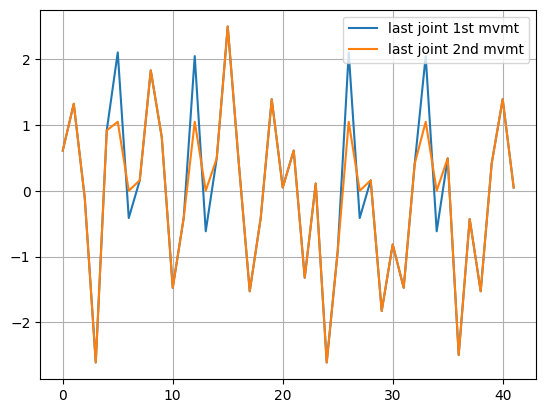

In [8]:
# Compare / save last joint position after 2nd movement
plt.plot(last_joint_angles, label="last joint 1st mvmt")
plt.plot(last_joint_angles_move2, label="last joint 2nd mvmt")
plt.legend()
plt.grid()

print(last_joint_angles_move2.shape)
for index, value in enumerate(last_joint_angles_move2):
    print(index, value)

### Move up the abdomen

##### Set up parameters for the simulation & fill in the data for legs angles and abdomen

In [11]:
# Fill all_joint_pos with abdomen control and last joint angles to move up the abdomen
nbre_steps = 5000 # Take 2 seconds

# Actuate abdomen --> move up to reach horizontal position
abdomen_control = 0.25*np.ones((nbre_steps, 4)) # shape (nbre_steps, 4)
last_abd_ctrl = 0.2*np.ones((nbre_steps,1)) # shape (nbre_steps, 1)
abdomen_ctrl_up = np.concatenate([abdomen_control, last_abd_ctrl], axis=1) # shape (nbre_steps, 5)

# Keep last position of the abdomen
last_abd_pos = abdomen_ctrl_up[-1,:] # shape (1,5)

# Keep all other joints at last position during the whole movement  
last_joint_angles_stable = last_joint_angles.copy()
joint_pos = np.tile(last_joint_angles_stable, (nbre_steps, 1)) # shape (nbre_steps, 42)
print(len(last_joint_angles_stable))
print(joint_pos.shape)

# Add abdomen control to all joint positions
all_joint_pos = np.concatenate([joint_pos, abdomen_ctrl_up], axis=1) # shape (nbre_steps, 47)

42
(5000, 42)


##### Simulation

In [18]:
# new nmf with actuated abdomen
sim_params = Parameters(timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_contacts=False,
    render_camera="Animat/camera_back",
)
nmf_act_abd = NeuromechflyProject(sim_params=sim_params,)

# Reset the simulation
nmf_act_abd.reset()

adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(nbre_steps):
    joint_angles = all_joint_pos[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf_act_abd.step(action)
    nmf_act_abd.render()

if sim_params.render_camera == "Animat/camera_back":
    nmf_act_abd.save_video("./outputs/up_abd_back.mp4")
elif sim_params.render_camera == "Animat/camera_left":
    nmf_act_abd.save_video("./outputs/up_abd_left.mp4")
elif sim_params.render_camera == "Animat/camera_right":
    nmf_act_abd.save_video("./outputs/up_abd_right.mp4")
elif sim_params.render_camera == "Animat/camera_front":    
    nmf_act_abd.save_video("./outputs/up_abd_front.mp4")

last_joint_angles_abd_up = all_joint_pos[-1].copy()

100%|██████████| 5000/5000 [00:21<00:00, 227.57it/s]


In [ ]:
Video("./outputs/up_abd.mp4")

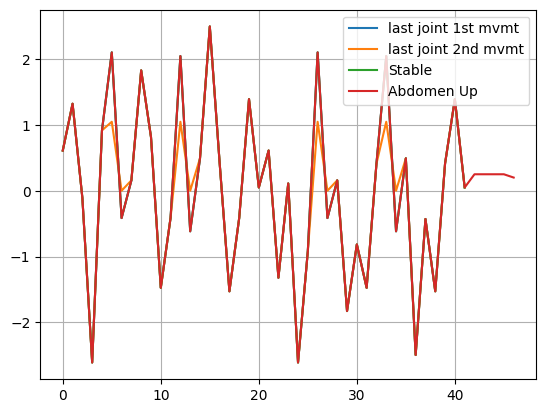

In [13]:
plt.plot(last_joint_angles, label="last joint 1st mvmt")
plt.plot(last_joint_angles_move2, label="last joint 2nd mvmt")
plt.plot(last_joint_angles_stable, label='Stable')
plt.plot(last_joint_angles_abd_up, label='Abdomen Up')
plt.grid()
plt.legend()

#### Groom abdomen
1. move up un peu l'abdomen
2. check les dernières positions des hindlegs
3. écarter les pattes arrière ---> changer COXA YAW
4. lever les pattes arrière ---> changer FEMUR PITCH
5. abaisser (à plat) la pattes arrière ---> changer FEMUR ROLL
6. 

(5000,)
(5000,)


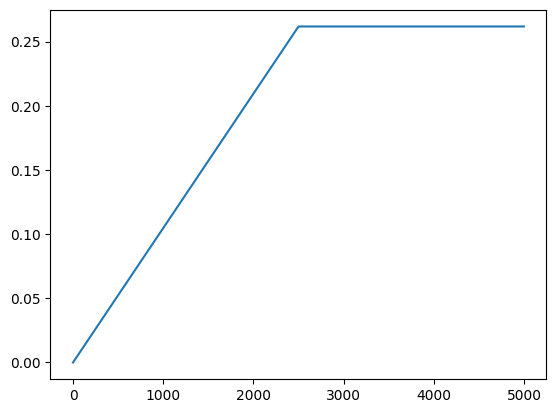

In [53]:
full_zero = np.zeros((5000))
print(full_zero.shape)
full_zero[:2500] = np.linspace(0, np.pi/12, 2500)
full_zero[2500:] = np.ones(2500)*np.pi/12
print(full_zero.shape)
plt.plot(full_zero)


In [108]:
nbre_steps = 5000 # Take 2 seconds
half_nbre_steps = int(nbre_steps/4)

##### Actuate abdomen --> move up to reach ~horizontal position
# abdomen_control = 0.175*np.ones((nbre_steps, 4)) # shape (nbre_steps, 4)
# last_abd_ctrl = 0.125*np.ones((nbre_steps,1)) # shape (nbre_steps, 1)
# abdomen_ctrl_up = np.concatenate([abdomen_control, last_abd_ctrl], axis=1) # shape (nbre_steps, 5)
abd_joint = np.zeros((nbre_steps))
abd_joint[:half_nbre_steps] = np.linspace(0, np.pi/12, half_nbre_steps)
abd_joint[half_nbre_steps:] = np.ones(nbre_steps-half_nbre_steps)*np.pi/12 # abd is up after 1 seconds and stays up
abd_joint = np.tile(abd_joint, (5, 1)).T # shape (nbre_steps, 5)

# Keep last position of the abdomen
last_abd_pos = abd_joint[-1,:] # shape (1,5)

# Keep all other joints at last position (end 1st mvnt) during the whole movement  
last_joint_angles_abd_groom = last_joint_angles.copy() # shape (42,)
 
joint_pos = np.tile(last_joint_angles_abd_groom, (nbre_steps, 1)) # shape (nbre_steps, 42)

                            ###### Actuate hindlegs #######
start_LH_COXA_YAW = last_joint_angles[LH_COXA_YAW] # angle left coxa yaw at the end of 1st movement
start_RH_COXA_YAW = last_joint_angles[RH_COXA_YAW] # angle right coxa yaw at the end of 1st movement
start_LH_COXA = last_joint_angles[LH_COXA] # angle left coxa at the end of 1st movement
start_RH_COXA = last_joint_angles[RH_COXA] # angle right coxa at the end of 1st movement
start_LH_FEMUR_ROLL = last_joint_angles[LH_FEMUR_ROLL] # angle left femur roll at the end of 1st movement
start_RH_FEMUR_ROLL = last_joint_angles[RH_FEMUR_ROLL] # angle right femur roll at the end of 1st movement
start_LH_FEMUR = last_joint_angles[LH_FEMUR] # angle left femur at the end of 1st movement
start_RH_FEMUR = last_joint_angles[RH_FEMUR] # angle right femur at the end of 1st movement
start_LH_TARSUS = last_joint_angles[LH_TARSUS] # angle left tarsus at the end of 1st movement
start_RH_TARSUS = last_joint_angles[RH_TARSUS] # angle right tarsus at the end of 1st movement

# Spread hindlegs
joint_pos[:,LH_COXA_YAW] = np.linspace(start_LH_COXA_YAW, start_LH_COXA_YAW-2*np.pi/5, nbre_steps)
joint_pos[:,RH_COXA_YAW] = np.linspace(start_RH_COXA_YAW, start_RH_COXA_YAW+2*np.pi/5, nbre_steps)

joint_pos[:,LH_FEMUR_ROLL] = np.linspace(start_LH_FEMUR_ROLL, start_LH_FEMUR_ROLL-np.pi/6, nbre_steps)
joint_pos[:,RH_FEMUR_ROLL] = np.linspace(start_RH_FEMUR_ROLL, start_RH_FEMUR_ROLL+np.pi/6, nbre_steps)

# Up hindlegs
# joint_pos[:,LH_COXA] = np.linspace(start_LH_COXA, start_LH_COXA+np.pi/6, nbre_steps)
# joint_pos[:,RH_COXA] = np.linspace(start_RH_COXA, start_RH_COXA+np.pi/6, nbre_steps)

joint_pos[:,LH_FEMUR] = np.linspace(start_LH_FEMUR, start_LH_FEMUR - np.pi/6, nbre_steps)
joint_pos[:,RH_FEMUR] = np.linspace(start_RH_FEMUR, start_RH_FEMUR - np.pi/6, nbre_steps)

# Spread tarsus
joint_pos[:,LH_TARSUS] = np.linspace(start_LH_TARSUS, start_LH_TARSUS-np.pi/3, nbre_steps)
joint_pos[:,RH_TARSUS] = np.linspace(start_RH_TARSUS, start_RH_TARSUS-np.pi/3, nbre_steps)

print(len(last_joint_angles_stable))
print(joint_pos.shape)

# Add abdomen control to all joint positions
all_joint_abd_groom = np.concatenate([joint_pos, abd_joint], axis=1) # shape (nbre_steps, 47)
 

42
(5000, 42)


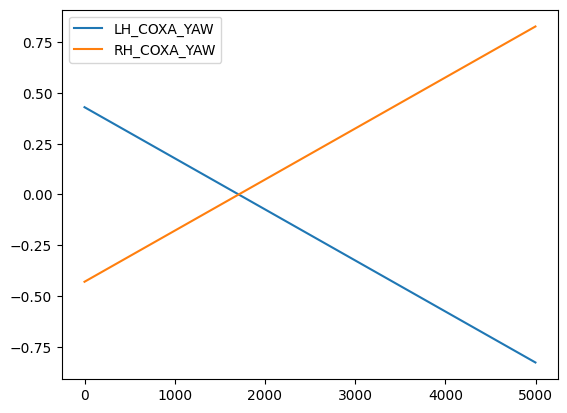

In [109]:
plt.plot(joint_pos[:,LH_COXA_YAW], label="LH_COXA_YAW")
plt.plot(joint_pos[:,RH_COXA_YAW], label="RH_COXA_YAW")
plt.legend()

Simulate

In [110]:
# new nmf with actuated abdomen
sim_params = Parameters(timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_contacts=False,
    render_camera="Animat/camera_left",
)
nmf_act_abd = NeuromechflyProject(sim_params=sim_params,)

# Reset the simulation
nmf_act_abd.reset()

adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(nbre_steps):
    joint_angles = all_joint_abd_groom[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf_act_abd.step(action)
    nmf_act_abd.render()

if sim_params.render_camera == "Animat/camera_back":
    nmf_act_abd.save_video("./outputs/groom_abd_back.mp4")
elif sim_params.render_camera == "Animat/camera_left":
    nmf_act_abd.save_video("./outputs/groom_abd_left.mp4")
elif sim_params.render_camera == "Animat/camera_right":
    nmf_act_abd.save_video("./outputs/groom_abd_right.mp4")
elif sim_params.render_camera == "Animat/camera_front":    
    nmf_act_abd.save_video("./outputs/groom_abd_front.mp4")
elif sim_params.render_camera == "Animat/camera_top":    
    nmf_act_abd.save_video("./outputs/groom_abd_top.mp4")
elif sim_params.render_camera == "Animat/camera_bottom":
    nmf_act_abd.save_video("./outputs/groom_abd_bottom.mp4")

last_joint_angles_abd_groom = all_joint_abd_groom[-1].copy()

100%|██████████| 5000/5000 [00:28<00:00, 178.57it/s]


#### Move the hind legs up

In [ ]:
nmf_act_abd.reset()
all_joint_angles = np.ones((target_num_steps, len(all_joint_angles[0])))

if i == 9: # LH Tarsus
    all_joint_angles[:,i] = np.linspace(last_joint_angles[9], 0, target_num_steps)
elif i == 41: # RH Tarsus
    all_joint_angles[:,i] = np.linspace(last_joint_angles[41], 0, target_num_steps)

for i in trange(target_num_steps):
    joint_angles = all_joint_angles[i,:]
    action = {"joints": joint_angles, "adhesion" : np.array([1,1,0,1,1,0])}
    #print("prog_action", action,'\n')
    nmf_act_abd.step(action)
    nmf_act_abd.render()
nmf_act_abd.save_video("./outputs/c.mp4")

In [ ]:
Video("./outputs/c.mp4")

In [ ]:
# plot hindleg joint positions
plt.figure(figsize=(15, 5))
plt.plot(all_joint_angles[:,8:9], label=["LH Tibia","LH Tarsus"])
plt.plot(all_joint_angles[:,14:15], label=["RH Tibia","RH Tarsus"])
plt.title("Hindleg joint positions")
plt.xlabel("Time step")
plt.ylabel("Joint angle")
plt.legend()
plt.show()

In [ ]:
observ = nmf.get_observation()
print(observ["end_effectors"])

#### Load grooming position of frontleg

In [ ]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep_groom = grooming_modules["timestep"]
target_num_steps_groom = int(1.0 / timestep_groom) # 10'000
target_joint_angles_front = grooming_modules["foreleg"][:, :target_num_steps]


In [ ]:
# all_joint_angles.shape() = (10000, 42)
# my all_joint_angles_groom_shape() = (558, 21)

# need to map the 21 joints to the 42 joints
target_joint_angles_front = target_joint_angles_front.T # (558, 21)
target_joint_angles_front = np.tile(target_joint_angles_front, (18, 1)) # (10044, 21)

joint_LHCoxa = target_joint_angles_front[:,3]

In [ ]:
print(joint_LHCoxa.shape)
print(joint_LHCoxa[:target_num_steps].shape)
test = np.ones((target_num_steps, len(all_joint_angles[0])))
print(test.shape)
print(target_num_steps)

#### Map the grooming position of the leg to the corresponding body part.

In [ ]:
joint_LHCoxa = target_joint_angles_front[:,3]
joint_LHCoxa_roll = target_joint_angles_front[:,4]
joint_LHCoxa_yaw = target_joint_angles_front[:,5]
joint_LHFemur = target_joint_angles_front[:,6]
joint_LHFemur_roll = target_joint_angles_front[:,7]
joint_LHTibia = target_joint_angles_front[:,8]
joint_LHTarsus = target_joint_angles_front[:,9]
joint_RHCoxa = target_joint_angles_front[:,10]
joint_RHCoxa_roll = target_joint_angles_front[:,11]
joint_RHCoxa_yaw = target_joint_angles_front[:,12]
joint_RHFemur = target_joint_angles_front[:,13]
joint_RHFemur_roll = target_joint_angles_front[:,14]
joint_RHTibia = target_joint_angles_front[:,15]
joint_RHTarsus = target_joint_angles_front[:,16]


all_joint_angles = np.ones((target_num_steps, len(all_joint_angles[0]))) # 10000, 42
print(all_joint_angles.shape)

all_joint_angles[:,14] = joint_LHCoxa[:target_num_steps] # jusqu'à 10'000
all_joint_angles[:,15] = joint_LHCoxa_roll[:target_num_steps]
all_joint_angles[:,16] = joint_LHCoxa_yaw[:target_num_steps]
all_joint_angles[:,17] = joint_LHFemur[:target_num_steps]
all_joint_angles[:,18] = joint_LHFemur_roll[:target_num_steps]
all_joint_angles[:,19] = joint_LHTibia[:target_num_steps]
all_joint_angles[:,20] = joint_LHTarsus[:target_num_steps]
all_joint_angles[:,35] = joint_RHCoxa[:target_num_steps]
all_joint_angles[:,36] = joint_RHCoxa_roll[:target_num_steps]
all_joint_angles[:,37] = joint_RHCoxa_yaw[:target_num_steps]
all_joint_angles[:,38] = joint_RHFemur[:target_num_steps]
all_joint_angles[:,39] = joint_RHFemur_roll[:target_num_steps]
all_joint_angles[:,40] = joint_RHTibia[:target_num_steps]
all_joint_angles[:,41] = joint_RHTarsus[:target_num_steps]


#### Simulation

In [ ]:
# test_front = grooming_modules["foreleg"][:, :target_num_steps]
# abd_arr = 0.25*np.ones((5, 558))
# test_front = np.concatenate((test_front, abd_arr), axis=0)
# print(test_front.shape)
# print(nmf.arena)
# print(nmf.init_pose)


for i in trange(target_num_steps/2):
    for k in range (len(all_joint_angles[0])):
        if k == 9: # LH Tarsus
            joint_angles = all_joint_angles[k,i + np.pi/2]
        elif k == 41: # RH Tarsus
            joint_angles = all_joint_angles[k,i + np.pi/2]
        else:
            joint_angles = all_joint_angles[k,i]
    action = {"joints": joint_angles, "adhesion" : np.array([1,1,0,1,1,0])}
    #print("prog_action", action,'\n')
    nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/main_groom.mp4")

In [ ]:
Video("./outputs/main_groom.mp4")